In [ ]:
# load dataset zip from drive and copies to local
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copy("/content/drive/MyDrive/DeepLearningProject_CrimeDetection/cddfiltered.zip","/content/cddfiltered.zip")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/cddfiltered.zip'

In [ ]:
# unzip dataset
!mkdir './cdd_dataset'
!unzip -o 'cddfiltered.zip' -d './cdd_dataset'

mkdir: cannot create directory ‘./cdd_dataset’: File exists
Archive:  cddfiltered.zip
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Stealing079_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Shoplifting049_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Shoplifting022_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Shoplifting016_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Stealing062_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Shoplifting044_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Burglary021_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Burglary035_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selection Clean Video/Test/Crime/Shoplifting007_x264.mp4  
  inflating: ./cdd_dataset/content/CDD Selec

In [ ]:
DATASET_TEST_PATH = "./cdd_dataset/content/CDD Selection Clean Video/Test"
DATASET_TRAIN_PATH = "./cdd_dataset/content/CDD Selection Clean Video/Train"
FRAME_COUNT = 12
TRAIN_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 16
TARGET_SIZE = (64, 64)

In [ ]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tqdm.auto import tqdm
import os
import cv2
import numpy as np

# custom data generator for rolling window samples for LSTM
# data generator is required or the size of data will bigger than the ram size
class VideoDataGenerator(Sequence):
    def __init__(self, dataset_path, batch_size, frame_count,use_memory=False, keep_video_capturer=False,balance_class = True, shuffle_video=True, shuffle_batch = True, rescale = 1/255., target_shape = (224,224), one_hot = True):
        # initialization

        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.shuffle_video = shuffle_video
        self.shuffle_batch = shuffle_batch
        self.rescale = rescale
        self.target_shape = target_shape
        self.one_hot = one_hot
        self.balance_class = balance_class
        self.keep_video_capturer = keep_video_capturer
        self.use_memory = use_memory
        
        self.class_count = len(os.listdir(self.dataset_path))

        self.class_data_count = {}

        self.class_frame_count = {}

        self.class_map = {}
        self.inverse_class_map = {}

        self.class_map = {f:idx for idx,f in enumerate(os.listdir(self.dataset_path))}
        self.inverse_class_map = {idx:f for idx,f in enumerate(os.listdir(self.dataset_path))}
        
        # video discovery
        self.total_files = 0
        self.video_list = []

        self._video_caps_dict = {}
        self._video_frame_dict = {}

        for class_name in self.class_map.keys():
            class_path = os.path.join(self.dataset_path, class_name)
            video_list = [f for f in os.listdir(class_path) if f.endswith(".mp4")]
            if not self.balance_class:
                video_list = tqdm(video_list)
            for video_name in video_list:
                if class_name not in self.class_frame_count:
                    self.class_frame_count[class_name] = 0
                generated_filepath = self._generator_filepath(class_name, video_name)
                if not self.balance_class:
                    video_list.set_description(f"Discovering {generated_filepath}")
                vcap = cv2.VideoCapture(generated_filepath)
                
                fr_count = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
                self.class_frame_count[class_name] += fr_count
                if self.balance_class:
                    self.video_list.append((class_name, video_name, fr_count))
                else:
                    self.video_list.append((class_name, video_name))
                    
                    if self.use_memory:
                        if not self.balance_class:
                            video_list.set_description(f"Prefetching {generated_filepath} to memory")
                        if generated_filepath not in self._video_frame_dict:
                            self._video_frame_dict[generated_filepath] = []
                        for i in range(fr_count):
                            vcap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
                            _, frame = vcap.read()
                            frame = cv2.resize(frame, self.target_shape)
                            frame = frame.astype(np.float32)
                            frame = self.rescale * frame
                            self._video_frame_dict[generated_filepath].append(frame)
                            if not self.balance_class:
                                video_list.update(1/fr_count)
                    else:
                        if not self.balance_class:
                            video_list.update(1)

                    if self.keep_video_capturer:
                        self._video_caps_dict[generated_filepath] = vcap
                    else:
                        vcap.release()
                self.total_files += 1
                

        # balancing dataset using undersampling

        if self.balance_class:

            print("\nCategory balance enabled!")
            print("Before:")
            print(self.class_frame_count)
            print("Balancing..")

            np.random.shuffle(self.video_list)
            count_list_target = list(self.class_frame_count.values())
            count_list_target.pop(count_list_target.index(max(count_list_target)))
            count_target = int(sum(count_list_target) / len(count_list_target))

            self.total_files = 0
            temp_video_list = []

            self.class_frame_count = {}

            video_list = tqdm(self.video_list)

            for class_name, video_name, fr_count in self.video_list:
                if class_name not in self.class_frame_count:
                        self.class_frame_count[class_name] = 0
                if self.class_frame_count[class_name] <= count_target:
                    self.class_frame_count[class_name] += fr_count
                    self.total_files += 1
                    temp_video_list.append((class_name, video_name))
                    generated_filepath = self._generator_filepath(class_name, video_name)
                    video_list.set_description(f"Discovering {generated_filepath}")
                    vcap = cv2.VideoCapture(generated_filepath)
                    if self.use_memory:
                        video_list.set_description(f"Prefetching {generated_filepath} to memory")
                        if generated_filepath not in self._video_frame_dict:
                            self._video_frame_dict[generated_filepath] = []
                        for i in range(fr_count):
                            vcap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
                            _, frame = vcap.read()
                            frame = cv2.resize(frame, self.target_shape)
                            frame = frame.astype(np.float32)
                            frame = self.rescale * frame
                            self._video_frame_dict[generated_filepath].append(frame)
                            video_list.update(2/(fr_count-1))
                    else:
                        video_list.update(1)
                    if self.keep_video_capturer:
                        self._video_caps_dict[generated_filepath] = vcap

            
            self.video_list = temp_video_list
            print("After:")
            print(self.class_frame_count)
            print()

        # shuffle video if True
        if shuffle_video:
            np.random.shuffle(self.video_list)

        # generate X_link and y
        class_list_tqdm = tqdm(total = self.total_files)

        self.X_link_list = []
        self.y_list = []

        self._X_link_queue = []
        self._y_queue = []

        for class_name, video_name in self.video_list:
            class_list_tqdm.set_description(f"Generating indices: {class_name}/{video_name}")
            X_link, y = self._generator_rolling_window_indices(class_name, video_name)
            self._push_to_queue(X_link, y)
            class_list_tqdm.update(1)
        class_list_tqdm.close()

        self.X_link_list = np.array(self.X_link_list)
        self.y_list = np.array(self.y_list)

        self._indices = np.arange(len(self.X_link_list))
        
        # shuffle batch if True
        if self.shuffle_batch:
            np.random.shuffle(self._indices)

        # set batch counter
        self.total_batch = len(self._indices) // self.batch_size
        self._batch_counter = 0
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.total_batch
    
    def __getitem__(self, index):
        # get batch indices
        batch_indices = self._indices[index*self.batch_size : (index+1) * self.batch_size]
        
        # get corresponding X_link and y
        X_link = self.X_link_list[batch_indices]
        y = self.y_list[batch_indices]

        # get corresponding X frames
        X = self._generator_X(X_link, y)

        # convert y if one_hot
        if self.one_hot and self.class_count > 2:
            y = tf.one_hot(y, self.class_count)
        else:
            y = tf.constant(y)

        return X, y


    def _generator_X(self, X_link, y):
        # returns image array

        X = []
        for (video_name, frame_idx), class_index in (zip(X_link, y)):
            class_name = self.inverse_class_map[class_index]
            filepath = self._generator_filepath(class_name, video_name)
            video_frames = []
            for i in range(int(frame_idx), int(frame_idx) + self.frame_count):
                frame = self._fetch_frame_video(filepath, i)
                video_frames.append(frame)
            X.append(video_frames)
            

        X = tf.constant(np.array(X))
        return X
            
    def _generator_filepath(self, class_name, video_name):
        # return a valid filepath
        return os.path.join(self.dataset_path, class_name, video_name)

    def _fetch_frame_video(self, filepath, index):

        if self.use_memory:
            return self._video_frame_dict[filepath][index]
            
        if self.keep_video_capturer:
            video_cap = self._video_caps_dict[filepath]
        else: video_cap = cv2.VideoCapture(filepath)

        video_cap.set(cv2.CAP_PROP_POS_FRAMES, int(index))
        _, frame = video_cap.read()
        frame = cv2.resize(frame, self.target_shape)
        frame = frame.astype(np.float32)
        frame = self.rescale * frame
        if not self.keep_video_capturer:
            video_cap.release()

        return frame

    def _generator_rolling_window_indices(self, class_name, video_name):
        # generates rolling data samples
        X_link = []
        y = []
        filepath = self._generator_filepath(class_name, video_name)
        if self.keep_video_capturer:
            video_cap = self._video_caps_dict[filepath]
        else: video_cap = cv2.VideoCapture(filepath)
        frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if not self.keep_video_capturer:
            video_cap.release()
        for i in range(frame_count - self.frame_count + 1):
            X_link.append((video_name, i))
            if class_name not in self.class_data_count:
                self.class_data_count[class_name] = 0
            self.class_data_count[class_name] += 1
            y.append(self.class_map[class_name])
        
        return X_link,y
    
    def _push_to_queue(self, X_link, y):
        # push to queue for batching
        self._X_link_queue.extend(X_link)
        self._y_queue.extend(y)
        
        if len(self._X_link_queue) >= self.batch_size:
            self.X_link_list.extend(self._X_link_queue[:self.batch_size])
            self.y_list.extend(self._y_queue[:self.batch_size])
            self._X_link_queue = self._X_link_queue[self.batch_size:]
            self._y_queue = self._y_queue[self.batch_size:]

    def next(self):
        elem = self[self._batch_counter]
        self._batch_counter += 1
        if self._batch_counter >= self.total_batch:
            self._batch_counter = 0
            self.on_epoch_end()
        return elem
    
    def on_epoch_end(self):
        if self.shuffle_batch:
            np.random.shuffle(self._indices)

In [ ]:
train_generator = VideoDataGenerator(
    dataset_path = DATASET_TRAIN_PATH,
    batch_size = TRAIN_BATCH_SIZE,
    frame_count = FRAME_COUNT,
    target_shape= TARGET_SIZE,
    use_memory = True # WILL EAT RAM LIKE ITS LAST SUPPER
)

test_generator = VideoDataGenerator(
    dataset_path = DATASET_TEST_PATH,
    batch_size = TEST_BATCH_SIZE,
    frame_count = FRAME_COUNT,
    target_shape= TARGET_SIZE,
    use_memory = True # WILL EAT RAM LIKE ITS LAST SUPPER
)


Category balance enabled!
Before:
{'Crime': 129597, 'Normal': 903984}
Balancing..


  0%|          | 0/1156 [00:00<?, ?it/s]

After:
{'Normal': 132523, 'Crime': 129597}



  0%|          | 0/520 [00:00<?, ?it/s]


Category balance enabled!
Before:
{'Crime': 15506, 'Normal': 59189}
Balancing..


  0%|          | 0/194 [00:00<?, ?it/s]

After:
{'Normal': 15526, 'Crime': 15506}



  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
train_generator = VideoDataGenerator(
    dataset_path = DATASET_TRAIN_PATH,
    batch_size = TRAIN_BATCH_SIZE,
    frame_count = FRAME_COUNT,
    target_shape= TARGET_SIZE,
    use_memory = True # WILL EAT RAM LIKE ITS LAST SUPPER
)

test_generator = VideoDataGenerator(
    dataset_path = DATASET_TEST_PATH,
    batch_size = TEST_BATCH_SIZE,
    frame_count = FRAME_COUNT,
    target_shape= TARGET_SIZE,
    use_memory = True # WILL EAT RAM LIKE ITS LAST SUPPER
)


Category balance enabled!
Before:
{'Crime': 129597, 'Normal': 903984}
Balancing..


  0%|          | 0/1156 [00:00<?, ?it/s]

After:
{'Crime': 129597, 'Normal': 146824}



  0%|          | 0/540 [00:00<?, ?it/s]


Category balance enabled!
Before:
{'Crime': 15506, 'Normal': 59189}
Balancing..


  0%|          | 0/194 [00:00<?, ?it/s]

After:
{'Normal': 17317, 'Crime': 15506}



  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
train_generator.class_data_count

{'Crime': 125681, 'Normal': 144800}

In [ ]:
test_generator.class_data_count

{'Crime': 15022, 'Normal': 16987}

In [ ]:
train_generator.class_map

{'Crime': 0, 'Normal': 1}

In [ ]:
len(train_generator)

228

In [ ]:
len(test_generator)

78

In [ ]:
train_generator[1][0].shape

TensorShape([1024, 12, 64, 64, 3])

In [ ]:
test_generator[1][0].shape

TensorShape([16, 12, 64, 64, 3])

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, TimeDistributed, Input,LSTM,Bidirectional,Concatenate, GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2 


input_layer = Input(shape=(FRAME_COUNT, TARGET_SIZE[0], TARGET_SIZE[1], 3))

time_distributed_convolution_1 = TimeDistributed(Conv2D(8, (3,3), activation="relu"), name= "time_spatial_distributed_feature_extractor_conv2d_1")(input_layer)
time_distributed_pooling = TimeDistributed(MaxPooling2D((2,2)), name="time_distributed_spatial_feature_extractor_maxpooling_1")(time_distributed_convolution_1)
time_distributed_convolution_2 = TimeDistributed(Conv2D(16, (3,3), activation="relu"), name="timestributed_feature_extractor_conv2d_2")(time_distributed_pooling)
time_distributed_pooling_2 = TimeDistributed(MaxPooling2D((2,2)), name="time_distributed_spatial_feature_extractor_maxpooling_2")(time_distributed_convolution_2)
time_distributed_convolution_3 = TimeDistributed(Conv2D(32, (3,3), activation="relu"), name="timestributed_spatial_feature_extractor_conv2d_3")(time_distributed_pooling_2)
time_distributed_pooling_3 = TimeDistributed(MaxPooling2D((2,2)), name="time_distributed_spatial_feature_extractor_maxpooling_3")(time_distributed_convolution_3)
time_distributed_flatten = TimeDistributed(Flatten(), name="time_distributed_spatial_feature_extractor_flatten")(time_distributed_pooling_3)

glo_max_pooling = GlobalMaxPooling1D(name="spatial_feature_extractor_globalmaxpooling1d")(time_distributed_flatten)

lstm_1 = LSTM(units=16, return_sequences=True, name = "temporal_feature_extractor_lstm_1")(time_distributed_flatten)
lstm_2 = LSTM(units=16, return_sequences=True, name = "temporal_feature_extractor_lstm_2")(lstm_1)

lstm_flatten = Flatten(name = "temporal_feature_extractor_flatten")(lstm_2)

dropout_lstm_1 = Dropout(0.2,name = "temporal_feature_extractor_dropout")(lstm_flatten)
lstm_dense = Dense(units=128,kernel_regularizer=L1L2(), activation='relu',name = "temporal_feature_extractor_dense")(dropout_lstm_1)
lstm_batch_norm = BatchNormalization(name = "temporal_feature_extractor_batchnorm")(lstm_dense)

dropout_glo_max_pooling_1 = Dropout(0.2,name = "spatial_feature_extractor_dropout")(glo_max_pooling)
glo_max_pooling_dense = Dense(units=64,kernel_regularizer=L1L2(), activation='relu',name = "spatial_feature_extractor_dense")(dropout_glo_max_pooling_1)
glo_max_batch_norm = BatchNormalization(name = "spatial_feature_extractor_batchnorm")(glo_max_pooling_dense)

time_and_space_concatenation = Concatenate(name="time_and_space_concatenation")([lstm_batch_norm, glo_max_batch_norm])
output_dropout = Dropout(0.2,name = "output_dropout")(time_and_space_concatenation)
output = Dense(units=1, activation='sigmoid')(output_dropout)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 time_spatial_distributed_featu  (None, 12, 62, 62,   224        ['input_12[0][0]']               
 re_extractor_conv2d_1 (TimeDis  8)                                                               
 tributed)                                                                                        
                                                                                                  
 time_distributed_spatial_featu  (None, 12, 31, 31,   0          ['time_spatial_distributed

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
MAX_EPOCH_LENGTH = 30
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
hist = model.fit(train_generator, epochs=MAX_EPOCH_LENGTH, validation_data = test_generator, callbacks=[callback])


Epoch 1/30
228/228 [==============================] - 157s 671ms/step - loss: 0.6109 - accuracy: 0.6772 - val_loss: 0.6757 - val_accuracy: 0.8293
Epoch 2/30
228/228 [==============================] - 152s 667ms/step - loss: 0.4481 - accuracy: 0.8021 - val_loss: 0.5403 - val_accuracy: 0.8542
Epoch 3/30
228/228 [==============================] - 153s 667ms/step - loss: 0.3257 - accuracy: 0.8773 - val_loss: 0.3104 - val_accuracy: 0.8774
Epoch 4/30
228/228 [==============================] - 153s 667ms/step - loss: 0.2458 - accuracy: 0.9113 - val_loss: 0.2215 - val_accuracy: 0.8910
Epoch 5/30
228/228 [==============================] - 152s 666ms/step - loss: 0.1907 - accuracy: 0.9314 - val_loss: 0.1773 - val_accuracy: 0.9175
Epoch 6/30
228/228 [==============================] - 153s 668ms/step - loss: 0.1508 - accuracy: 0.9485 - val_loss: 0.1587 - val_accuracy: 0.9431
Epoch 7/30
228/228 [==============================] - 154s 674ms/step - loss: 0.1207 - accuracy: 0.9593 - val_loss: 0.1504 -

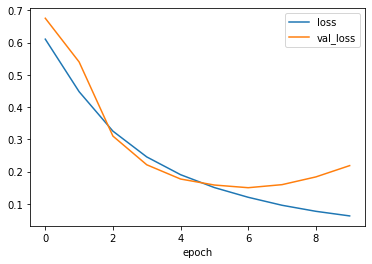

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history ["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.xlabel('epoch')
plt.legend()
plt.show()


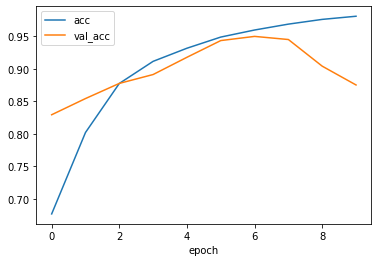

In [ ]:
plt.plot(hist.history["accuracy"],label="acc")
plt.plot(hist.history["val_accuracy"],label="val_acc")
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.save("./crime_det.h5")

In [ ]:
shutil.copy("/content/crime_det.h5","/content/drive/MyDrive/DeepLearningProject_CrimeDetection/crime_det.h5")

'/content/drive/MyDrive/DeepLearningProject_CrimeDetection/crime_det.h5'

In [ ]:
# training mobilenet

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, TimeDistributed, Input,LSTM,Bidirectional,Concatenate, GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2 

mobilenet_mobilenetv3small_minim = MobileNetV3Small(
    minimalistic=True,
    include_top=False,
    weights="imagenet", input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

mobilenet_input_layer = Input(shape=(FRAME_COUNT, TARGET_SIZE[0], TARGET_SIZE[1], 3))

mobilenet_time_distributed_mobilenetv3 = TimeDistributed(mobilenet_mobilenetv3small_minim,name="mobilenet_time_distributed_mobilenetsmallv3_minim")(mobilenet_input_layer)
mobilenet_time_distributed_flatten = TimeDistributed(Flatten(), name="mobilenet_time_distributed_spatial_feature_extractor_flatten")(mobilenet_time_distributed_mobilenetv3)


mobilenet_lstm_1 = LSTM(units=16, return_sequences=True, name = "mobilenet_temporal_feature_extractor_lstm_1")(mobilenet_time_distributed_flatten)
mobilenet_lstm_2 = LSTM(units=16, return_sequences=True, name = "mobilenet_temporal_feature_extractor_lstm_2")(mobilenet_lstm_1)

mobilenet_lstm_flatten = Flatten(name = "mobilenet_temporal_feature_extractor_flatten")(mobilenet_lstm_2)

mobilenet_dropout_lstm_1 = Dropout(0.2,name = "mobilenet_temporal_feature_extractor_dropout")(mobilenet_lstm_flatten)
mobilenet_lstm_dense = Dense(units=128,kernel_regularizer=L1L2(), activation='relu',name = "mobilenet_temporal_feature_extractor_dense")(mobilenet_dropout_lstm_1)
mobilenet_lstm_batch_norm = BatchNormalization(name = "mobilenet_temporal_feature_extractor_batchnorm")(mobilenet_lstm_dense)

mobilenet_output = Dense(units=1, activation='sigmoid')(mobilenet_lstm_batch_norm)

mobilenet_model = Model(inputs=mobilenet_input_layer, outputs=mobilenet_output)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 mobilenet_time_distributed_  (None, 12, 2, 2, 576)    441000    
 mobilenetsmallv3_minim (Tim                                     
 eDistributed)                                                   
                                                                 
 mobilenet_time_distributed_  (None, 12, 2304)         0         
 spatial_feature_extractor_f                                     
 latten (TimeDistributed)                                        
                                                                 
 mobilenet_temporal_feature_  (None, 12, 16)           148544    
 extractor_lstm_1 (LSTM)                                         
                                                           

In [ ]:
mobilenet_mobilenetv3small_minim.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 32, 32, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 32, 32, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
MAX_EPOCH_LENGTH = 30
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
mobilenet_hist = mobilenet_model.fit(train_generator, epochs=MAX_EPOCH_LENGTH, validation_data = test_generator, callbacks=[callback])

Epoch 1/30
519/519 [==============================] - 127s 233ms/step - loss: 0.3565 - accuracy: 0.8423 - val_loss: 1.0825 - val_accuracy: 0.1433
Epoch 2/30
519/519 [==============================] - 117s 225ms/step - loss: 0.1053 - accuracy: 0.9647 - val_loss: 1.1789 - val_accuracy: 0.1719
Epoch 3/30
519/519 [==============================] - 117s 225ms/step - loss: 0.0386 - accuracy: 0.9893 - val_loss: 2.6098 - val_accuracy: 0.1433
Epoch 4/30
519/519 [==============================] - 117s 225ms/step - loss: 0.0161 - accuracy: 0.9970 - val_loss: 2.4109 - val_accuracy: 0.3648
Epoch 4: early stopping


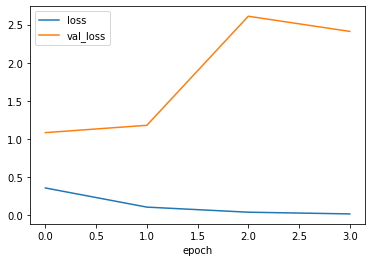

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mobilenet_hist.history ["loss"],label="loss")
plt.plot(mobilenet_hist.history["val_loss"],label="val_loss")
plt.xlabel('epoch')
plt.legend()
plt.show()


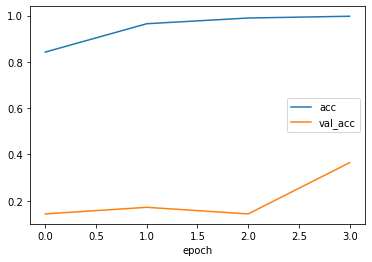

In [ ]:
plt.plot(mobilenet_hist.history["accuracy"],label="acc")
plt.plot(mobilenet_hist.history["val_accuracy"],label="val_acc")
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
mobilenet_model.save("./mobilenet_crime_det.h5")

In [ ]:
shutil.copy("/content/mobilenet_crime_det.h5","/content/drive/MyDrive/DeepLearningProject_CrimeDetection/mobilenet_crime_det.h5")

'/content/drive/MyDrive/DeepLearningProject_CrimeDetection/mobilenet_crime_det.h5'